In [1]:
pip install joblib

Note: you may need to restart the kernel to use updated packages.


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Transaction ID   1000 non-null   object 
 1   Timestamp        1000 non-null   object 
 2   Sender Name      1000 non-null   object 
 3   Sender UPI ID    1000 non-null   object 
 4   Receiver Name    1000 non-null   object 
 5   Receiver UPI ID  1000 non-null   object 
 6   Amount (INR)     1000 non-null   float64
 7   Status           1000 non-null   object 
dtypes: float64(1), object(7)
memory usage: 62.6+ KB
None

Dataset Description:
       Amount (INR)
count   1000.000000
mean    4999.022930
std     2873.484534
min       28.520000
25%     2521.620000
50%     4951.435000
75%     7315.835000
max     9993.060000

First Few Rows of Dataset:
                         Transaction ID            Timestamp      Sender Name  \
0  4d3db980-46cd-4158-a812-dcb77055d0d2  2024

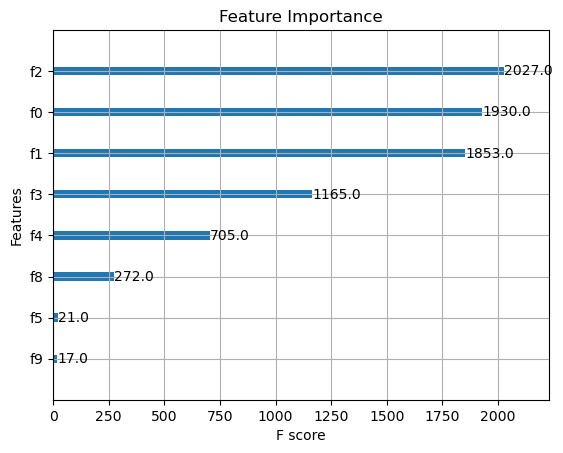


Storing the model...
Model saved as 'upi_transaction_model_xgb_best.joblib'

Transaction Status Distribution:
Status
1    502
0    498
Name: count, dtype: int64


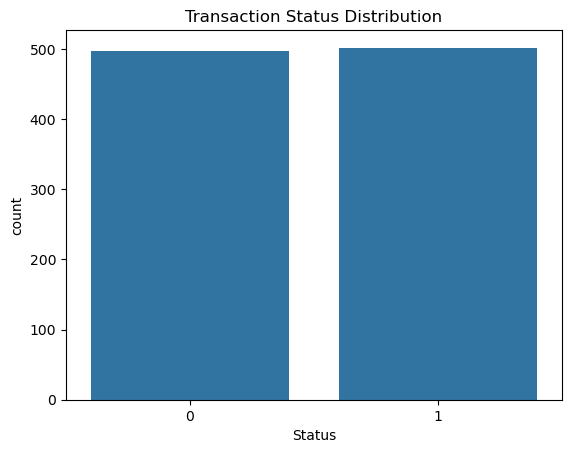


Amount Distribution:


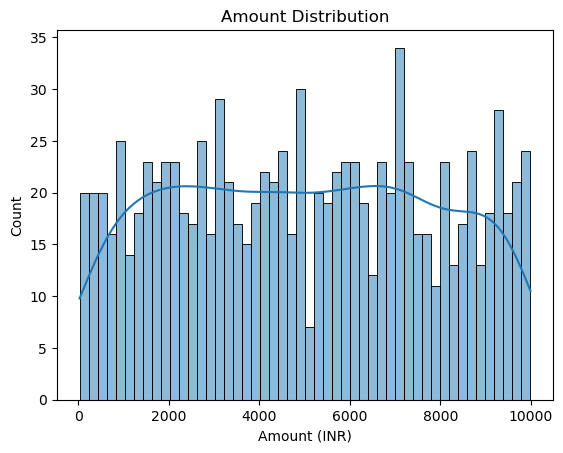


Transaction Count by Hour:


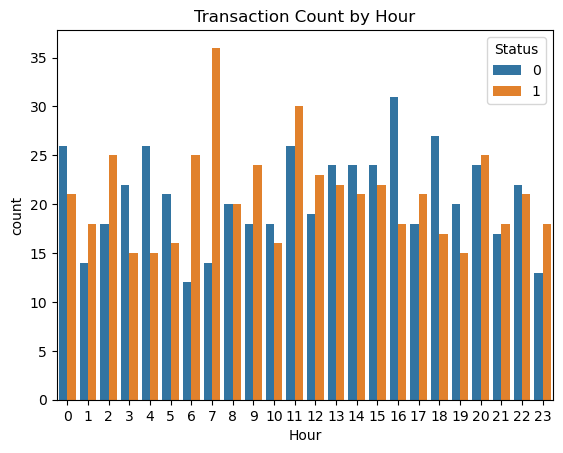


Transaction Count by Day of the Week:


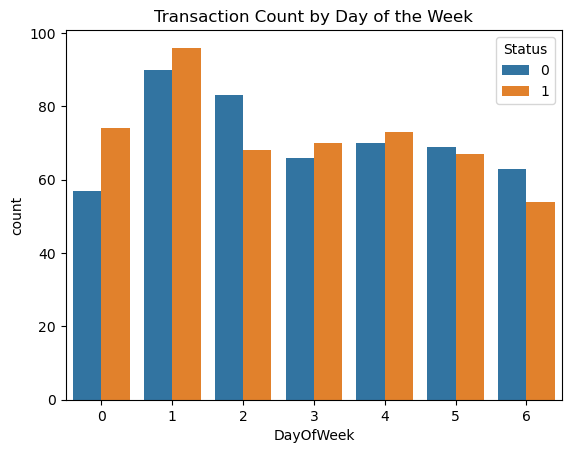

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import joblib
import xgboost as xgb

# Load the dataset
df = pd.read_csv('transactions.csv')

# Display basic information about the dataset
print("Dataset Information:")
print(df.info())
print("\nDataset Description:")
print(df.describe())
print("\nFirst Few Rows of Dataset:")
print(df.head())

# Convert the Timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Extract additional time-related features
df['Date'] = df['Timestamp'].dt.date
df['Hour'] = df['Timestamp'].dt.hour
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

# Encode categorical variables
le = LabelEncoder()
df['Sender UPI ID'] = le.fit_transform(df['Sender UPI ID'])
df['Receiver UPI ID'] = le.fit_transform(df['Receiver UPI ID'])
df['Sender Name'] = le.fit_transform(df['Sender Name'])
df['Receiver Name'] = le.fit_transform(df['Receiver Name'])

# Create user transaction history features
df['Sender_Transaction_Count'] = df.groupby('Sender UPI ID')['Transaction ID'].transform('count')
df['Receiver_Transaction_Count'] = df.groupby('Receiver UPI ID')['Transaction ID'].transform('count')
df['Sender_Total_Amount'] = df.groupby('Sender UPI ID')['Amount (INR)'].transform('sum')
df['Receiver_Total_Amount'] = df.groupby('Receiver UPI ID')['Amount (INR)'].transform('sum')
df['Sender_Avg_Amount'] = df.groupby('Sender UPI ID')['Amount (INR)'].transform('mean')
df['Receiver_Avg_Amount'] = df.groupby('Receiver UPI ID')['Amount (INR)'].transform('mean')

# Prepare the data for modeling
df['Status'] = df['Status'].map({'SUCCESS': 1, 'FAILED': 0})
features = [
    'Amount (INR)', 'Sender UPI ID', 'Receiver UPI ID', 'Hour', 'DayOfWeek', 'IsWeekend',
    'Sender_Transaction_Count', 'Receiver_Transaction_Count',
    'Sender_Total_Amount', 'Receiver_Total_Amount',
    'Sender_Avg_Amount', 'Receiver_Avg_Amount'
]
X = df[features]
y = df['Status']

# Split the data into training and testing sets
print("\nSplitting data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle imbalanced data
print("\nHandling imbalanced data using SMOTE...")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Scale features
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

# Hyperparameter tuning using RandomizedSearchCV for XGBoost
print("\nStarting hyperparameter tuning using RandomizedSearchCV for XGBoost...")
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

xgb_clf = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
random_search = RandomizedSearchCV(estimator=xgb_clf, param_distributions=param_dist, n_iter=50, scoring='accuracy', cv=3, verbose=2, n_jobs=-1, random_state=42)
random_search.fit(X_train_resampled, y_train_resampled)

# Best parameters
print(f"\nBest parameters found: {random_search.best_params_}")

# Train the model with the best parameters
print("\nTraining the model with the best parameters...")
best_xgb = random_search.best_estimator_
best_xgb.fit(X_train_resampled, y_train_resampled)

# Make predictions
print("\nMaking predictions...")
y_pred = best_xgb.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Cross-validation
print("\nPerforming cross-validation...")
cv_scores = cross_val_score(best_xgb, X, y, cv=5)
print(f"\nCross-validation scores: {cv_scores}")
print(f"\nMean cross-validation score: {cv_scores.mean()}")

# Visualizing feature importance
print("\nVisualizing feature importance...")
xgb.plot_importance(best_xgb)
plt.title('Feature Importance')
plt.show()

# Store the model
print("\nStoring the model...")
joblib.dump(best_xgb, 'upi_transaction_model_xgb_best.joblib')
print("Model saved as 'upi_transaction_model_xgb_best.joblib'")

print("\nTransaction Status Distribution:")
print(df['Status'].value_counts())
sns.countplot(data=df, x='Status')
plt.title('Transaction Status Distribution')
plt.show()

print("\nAmount Distribution:")
sns.histplot(df['Amount (INR)'], bins=50, kde=True)
plt.title('Amount Distribution')
plt.show()

print("\nTransaction Count by Hour:")
sns.countplot(data=df, x='Hour', hue='Status')
plt.title('Transaction Count by Hour')
plt.show()

print("\nTransaction Count by Day of the Week:")
sns.countplot(data=df, x='DayOfWeek', hue='Status')
plt.title('Transaction Count by Day of the Week')
plt.show()
